In [1]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    batch_size = 32
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision

    device = "cuda"
    random_state = 42 


config = TrainingConfig()

In [2]:
import os
import random

import numpy as np
import torch


def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:
    
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)
    
   
seed_everything(config.random_state)

In [9]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im
    


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import torch

model = torch.load("food101_conditional_ddpm/model_44.pt")

In [6]:
from diffusers import DDPMPipeline, DDPMScheduler
from tqdm.auto import tqdm 

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, 
    beta_schedule="linear"
)

noise_scheduler.set_timesteps(num_inference_steps=1000)

noise_scheduler.timesteps

tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990, 989, 988, 987, 986,
        985, 984, 983, 982, 981, 980, 979, 978, 977, 976, 975, 974, 973, 972,
        971, 970, 969, 968, 967, 966, 965, 964, 963, 962, 961, 960, 959, 958,
        957, 956, 955, 954, 953, 952, 951, 950, 949, 948, 947, 946, 945, 944,
        943, 942, 941, 940, 939, 938, 937, 936, 935, 934, 933, 932, 931, 930,
        929, 928, 927, 926, 925, 924, 923, 922, 921, 920, 919, 918, 917, 916,
        915, 914, 913, 912, 911, 910, 909, 908, 907, 906, 905, 904, 903, 902,
        901, 900, 899, 898, 897, 896, 895, 894, 893, 892, 891, 890, 889, 888,
        887, 886, 885, 884, 883, 882, 881, 880, 879, 878, 877, 876, 875, 874,
        873, 872, 871, 870, 869, 868, 867, 866, 865, 864, 863, 862, 861, 860,
        859, 858, 857, 856, 855, 854, 853, 852, 851, 850, 849, 848, 847, 846,
        845, 844, 843, 842, 841, 840, 839, 838, 837, 836, 835, 834, 833, 832,
        831, 830, 829, 828, 827, 826, 825, 824, 823, 822, 821, 8

# Custom Inference function

In [7]:
def generate(x, model, noise_scheduler, num_inference_steps: int = 1000):
    model.eval()

    bs = x.shape[0]

    y = torch.randint(
            0, 101, (bs,), device=config.device
        ).long()
    
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    for t in tqdm(noise_scheduler.timesteps):
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(bs,), 
            fill_value=t.item(), 
            dtype=torch.long
        ).cuda()

        with torch.no_grad():
            noise_pred = model(
                model_input, 
                t_batch, 
                y,
                return_dict=False
            )[0]

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x

  0%|          | 0/1000 [00:00<?, ?it/s]

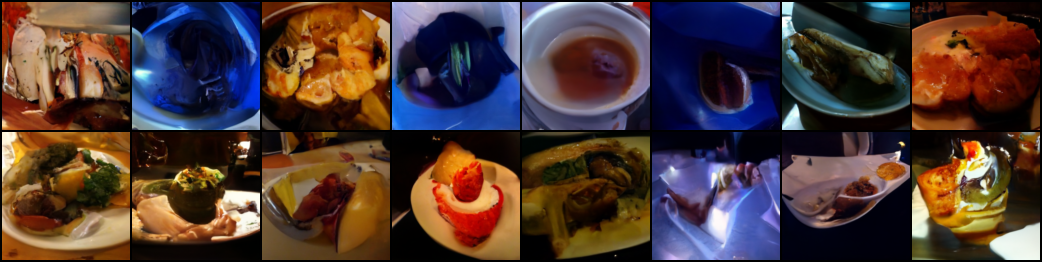

In [12]:
generated = generate(
    torch.randn((16, 3, 128, 128)).cuda(), 
    model, 
    noise_scheduler,
    num_inference_steps=1000
).cpu()

show_images(generated)

# Color Guidance

In [13]:
def color_loss(images, target_color=(0.9, 0.2, 0.2)):
    """Given a target color (R, G, B) return a loss for how far away on average
    the images' pixels are from that color. Defaults to a light teal: (0.1, 0.9, 0.5)"""
    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )  # Map target color to (-1, 1)
    target = target[
        None, :, None, None
    ]  # Get shape right to work with the images (b, c, h, w)
    error = torch.abs(
        images - target
    ).mean()  # Mean absolute difference between the image pixels and the target color
    return error

  0%|          | 0/100 [00:00<?, ?it/s]

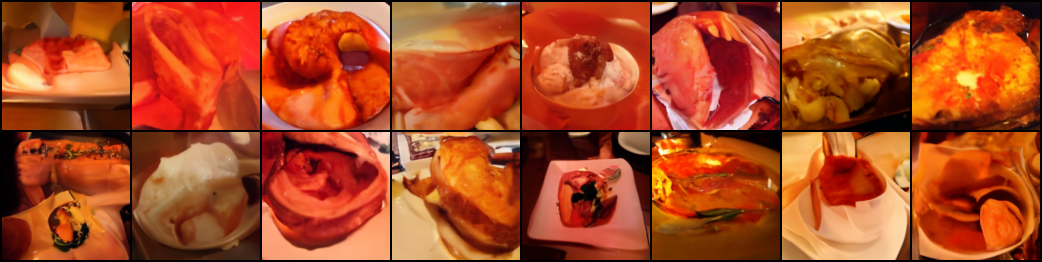

In [16]:
# Variant 1: shortcut method

# The guidance scale determines the strength of the effect
guidance_loss_scale = 20  # Explore changing this to 5, or 100

noise_scheduler.set_timesteps(num_inference_steps=100)

y = torch.randint(
        0, 101, (16,), device=config.device
    ).long()

x = torch.randn(16, 3, 128, 128).to(device)

for t in tqdm(noise_scheduler.timesteps):

    # Prepare the model input
    model_input = noise_scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = model(model_input, t, y, return_dict=False)[0]

    # Set x.requires_grad to True
    x = x.detach().requires_grad_()

    # Get the predicted x0
    x0 = noise_scheduler.step(noise_pred, t, x).pred_original_sample

    # Calculate loss
    loss = color_loss(x0) * guidance_loss_scale
    # if i % 10 == 0:
    #     print(i, "loss:", loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = noise_scheduler.step(noise_pred, t, x).prev_sample


show_images(x)